In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import Linear
from torch.nn import Conv2d, MaxPool2d, Flatten, Sequential
from torch.nn import L1Loss, MSELoss, CrossEntropyLoss
import torch.optim.lr_scheduler as lr_scheduler

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
import shutil

import time


In [47]:
# subdirectory
now = datetime.now()
logdir = "tb_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

# Check if the directoryexists
if os.path.exists(logdir):
    # Delete the directory and all its contents
    shutil.rmtree(logdir)

# recreate the directory if plan to continue logging
os.makedirs(logdir, exist_ok=True)

In [2]:
train_data = torchvision.datasets.CIFAR10(root="../data", train=True, transform=torchvision.transforms.ToTensor())

In [5]:
test_data = torchvision.datasets.CIFAR10(root="../data", train=False, transform=torchvision.transforms.ToTensor())

In [8]:
# check length

print(f"train data length {len(train_data)}")
print(f"test data length {len(test_data)}")

train data length 50000
test data length 10000


## dataloader

In [9]:
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

## CIFAR10
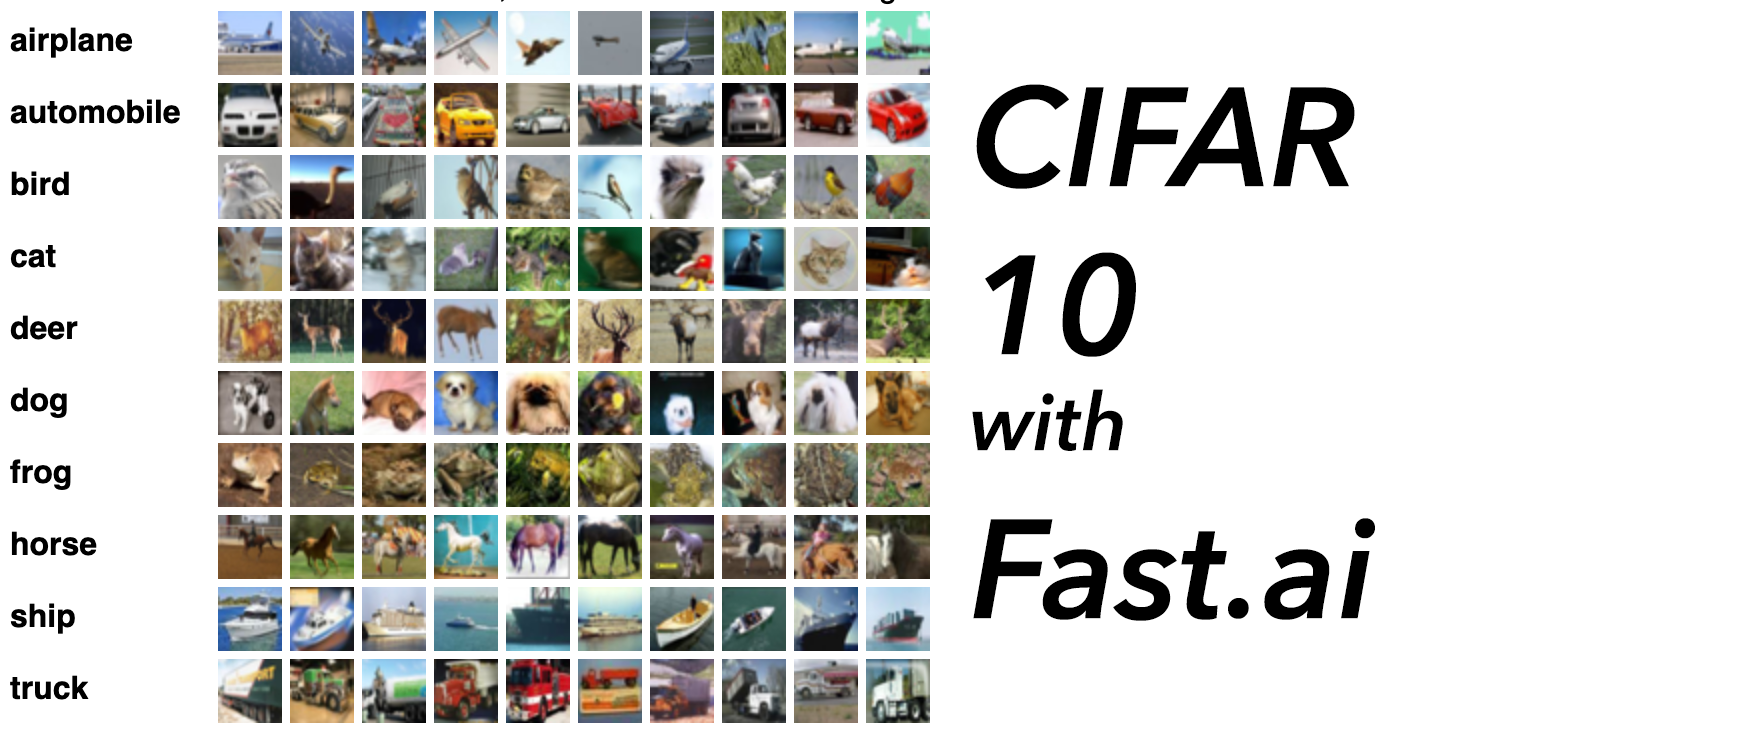

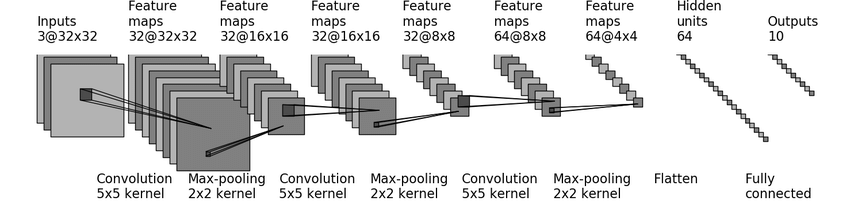

## built model

In [54]:
class nn_model(nn.Module):
    def __init__(self):
        super(nn_model, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*4*4, 64),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.model(x)
        return x


## unit test

In [31]:
# test code

nn_model = nn_model()
input = torch.ones((64, 3, 32, 32))
output = nn_model(input)
print(output.shape)



torch.Size([64, 10])


## create model instance

In [55]:
nn_model = nn_model()
if torch.cuda.is_available():
    nn_model = nn_model.cuda()

## loss function

In [56]:
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.cuda()

## optimizer

In [57]:
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)

## training and validation

In [60]:
# set train num and test num

epoch = 1
# tensorboard
writer = SummaryWriter(logdir)

start_time = time.time()
for i in range(epoch):

    # 訓練開始
    nn_model.train()
    print(f"第 {i} 輪訓練")
    total_training_step = 0
    total_testing_step = 0

    for data in train_dataloader:
        imgs, targets = data
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            targets = targets.cuda()

        outputs = nn_model(imgs)
        loss = loss_fn(outputs, targets)
        
        # 優化器優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_training_step += 1

        if total_training_step % 100 == 0:
            print(f"----------第 {total_training_step} 次訓練, loss = {loss}----------")
            writer.add_scalar("train_loss", loss.item(), total_training_step)

    # 測試開始
    nn_model.eval()
    total_test_loss = 0
    total_accuracy = 0

    with torch.no_grad():
        for data in test_dataloader:
            imgs, targets = data

            if torch.cuda.is_available():
                imgs = imgs.cuda()
                targets = targets.cuda()

            outputs = nn_model(imgs)

            loss = loss_fn(outputs, targets)

            total_test_loss += loss

            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy = total_accuracy + accuracy


            total_testing_step += 1

            if total_testing_step % 10 == 0:
                print(f"----------第 {total_testing_step} 測試, loss = {loss}----------")
                writer.add_scalar("test_loss", loss.item(), total_testing_step)
                writer.add_scalar("test_accuracy", total_accuracy/len(test_data), total_testing_step)


    print(f"整體數據集的 loss {total_test_loss}")
    print(f"整體測試集上的正確率 {total_accuracy/len(test_data)}")

    torch.save(nn_model.state_dict(), f"nn_model_CIFAR10_{i}_state_dict.pth")
    print("model saved")

end_time = time.time() 
writer.close()

print(f"total consume time is {end_time - start_time}")
      



第 0 輪訓練
----------第 100 次訓練, loss = 1.7047239542007446----------
----------第 200 次訓練, loss = 1.7268813848495483----------
----------第 300 次訓練, loss = 1.669366478919983----------
----------第 400 次訓練, loss = 1.5904631614685059----------
----------第 500 次訓練, loss = 1.665784239768982----------
----------第 600 次訓練, loss = 1.6850621700286865----------
----------第 700 次訓練, loss = 1.7468007802963257----------
----------第 10 測試, loss = 1.6163828372955322----------
----------第 20 測試, loss = 1.8258888721466064----------
----------第 30 測試, loss = 1.840773344039917----------
----------第 40 測試, loss = 2.053771734237671----------
----------第 50 測試, loss = 1.5964124202728271----------
----------第 60 測試, loss = 1.6551960706710815----------
----------第 70 測試, loss = 1.6606656312942505----------
----------第 80 測試, loss = 1.6192079782485962----------
----------第 90 測試, loss = 1.6040838956832886----------
----------第 100 測試, loss = 1.7197843790054321----------
----------第 110 測試, loss = 1.82010018825531---